## Generate predictions from models

### Import packages 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tfkl = tf.keras.layers
import pandas as pd
from scipy.stats import linregress

### Import functions

In [2]:
import evaluation_functions
import importlib
importlib.reload(evaluation_functions)

<module 'evaluation_functions' from '/Users/paigepark/Library/Mobile Documents/com~apple~CloudDocs/Desktop/deep-mort/code/evaluation_functions.py'>

### Import data

In [3]:
state_training = np.loadtxt('../data/state_training.txt')
state_test = np.loadtxt('../data/state_test.txt')

In [4]:
country_training = np.loadtxt('../data/country_training.txt')
country_test = np.loadtxt('../data/country_test.txt')

In [5]:
combined_training = np.loadtxt('../data/combined_training.txt')
combined_test = np.loadtxt('../data/combined_test.txt')

In [6]:
geos_key = np.load('../data/geos_key.npy')
geo_dict = {int(code): geo for geo, code in geos_key}

In [7]:
# convert actual test data to log scale
country_test[:,4][country_test[:,4] == 0] = 9e-06
country_test[:,4] = np.log(country_test[:,4])

In [8]:
# convert actual test data to log scale
combined_test[:,4][combined_test[:,4] == 0] = 9e-06
combined_test[:,4] = np.log(combined_test[:,4])

### Import predictions

In [9]:
# DL predictions - trained on all countries
dl_test_pred = []
for i in range(1,6):
    dl_test_pred.append(np.loadtxt(f"../data/dl_country_forecast_{i}.txt"))

# LC predictions
lc_test_pred = []
for i in range(1,6):
    lc_test_pred_temp = np.loadtxt(f"../data/lc_forecast_{i}.csv", delimiter=",")
    lc_test_pred_temp = lc_test_pred_temp[np.lexsort((lc_test_pred_temp[:, 1], lc_test_pred_temp[:, 3], lc_test_pred_temp[:, 2], lc_test_pred_temp[:, 0]))]
    lc_test_pred_temp[:,4][lc_test_pred_temp[:,4] == 0] = 9e-06
    lc_test_pred_temp[:,4] = np.log(lc_test_pred_temp[:,4])
    lc_test_pred.append(lc_test_pred_temp)

# hyndman-ullah predictions
hu_test_pred = []
for i in range(1,6):
    hu_test_pred_temp = np.loadtxt(f"../data/hu_forecast_{i}.csv", delimiter=",")
    hu_test_pred_temp = hu_test_pred_temp[np.lexsort((hu_test_pred_temp[:, 1], hu_test_pred_temp[:, 3], hu_test_pred_temp[:, 2], hu_test_pred_temp[:, 0]))]
    hu_test_pred_temp[:,4][hu_test_pred_temp[:,4] == 0] = 9e-06
    hu_test_pred_temp[:,4] = np.log(hu_test_pred_temp[:,4])
    hu_test_pred.append(hu_test_pred_temp)

# coherent predictions
c_test_pred = []
for i in range(1,6):
    c_test_pred_temp = np.loadtxt(f"../data/coherent_forecast_{i}.csv", delimiter=",")
    c_test_pred_temp = c_test_pred_temp[np.lexsort((c_test_pred_temp[:, 1], c_test_pred_temp[:, 3], c_test_pred_temp[:, 2], c_test_pred_temp[:, 0]))]
    c_test_pred_temp[:,4][c_test_pred_temp[:,4] == 0] = 9e-06
    c_test_pred_temp[:,4] = np.log(c_test_pred_temp[:,4])
    c_test_pred.append(c_test_pred_temp)

# DL predictions - trained on all countries and states
combined_test_pred = []
for i in range(1,6):
    combined_test_pred.append(np.loadtxt(f"../data/dl_combined_forecast_{i}.txt"))

In [10]:
geo_dict_countries_only = dict(list(geo_dict.items())[-40:])

In [11]:
# loading in single country / single gender predictions 
single_preds_combined = []

for j in range(1,6):
    preds_for_iter = []
    for geo in geo_dict_countries_only.values():
        for gender in range(2):
            single_pred = np.load(f"../data/single_preds/{geo}_gender_{gender}_iter_{j}.npz")
            arr = list(single_pred.values())[0]
            preds_for_iter.append(arr)

    combined_array = np.vstack(preds_for_iter)
    
    single_preds_combined.append(combined_array)


Prep data

In [12]:
actual_data_divided = []
actual_combined_divided = []
dl_test_divided = [[] for _ in range(5)]
combined_test_divided = [[] for _ in range(5)]
lc_test_divided = [[] for _ in range(5)]
hu_test_divided = [[] for _ in range(5)]
c_test_divided = [[] for _ in range(5)]
single_test_divided = [[] for _ in range(5)]

for j in range(5):
    for i in range(90):
        actual_combined_divided.append(combined_test[combined_test[:,0] == i])
        combined_test_divided[j].append(combined_test_pred[j][combined_test_pred[j][:, 0] == i])

for j in range(5):
    for i in range(50,90):
        actual_data_divided.append(country_test[country_test[:, 0] == i])
        dl_test_divided[j].append(dl_test_pred[j][dl_test_pred[j][:, 0] == i])
        lc_test_divided[j].append(lc_test_pred[j][lc_test_pred[j][:, 0] == i])
        hu_test_divided[j].append(hu_test_pred[j][hu_test_pred[j][:, 0] == i])
        c_test_divided[j].append(c_test_pred[j][c_test_pred[j][:, 0] == i])
        single_test_divided[j].append(single_preds_combined[j][single_preds_combined[j][:, 0] == i])


# Figures in Paper

### Overall performance (Figure 1)

In [13]:
lc_all = []
hu_all = []
coh_all = []
dl_all = []
single_all = []

for j in range(5):
    lc_mse_results_by_country = []
    hu_mse_results_by_country = []
    coh_mse_results_by_country = []
    dl_mse_results_by_country = []
    single_mse_results_by_country = []
    for i in range(0,40):
        lc_mse_overall, lc_rmse_overall, lc_rrmse_overall = evaluation_functions.calculate_error(lc_test_divided[j][i], actual_data_divided[i])
        hu_mse_overall, hu_rmse_overall, hu_rrmse_overall = evaluation_functions.calculate_error(hu_test_divided[j][i], actual_data_divided[i])
        coh_mse_overall, coh_rmse_overall, coh_rrmse_overall = evaluation_functions.calculate_error(c_test_divided[j][i], actual_data_divided[i])
        dl_mse_overall, dl_rmse_overall, dl_rrmse_overall = evaluation_functions.calculate_error(dl_test_divided[j][i], actual_data_divided[i])
        single_mse_overall, single_rmse_overall, single_rrmse_overall = evaluation_functions.calculate_error(single_test_divided[j][i], actual_data_divided[i]) 
        
        lc_mse_results_by_country.append(lc_mse_overall)
        hu_mse_results_by_country.append(hu_mse_overall)
        coh_mse_results_by_country.append(coh_mse_overall)
        dl_mse_results_by_country.append(dl_mse_overall)
        single_mse_results_by_country.append(single_mse_overall)

    lc_all.append(np.array(lc_mse_results_by_country))
    hu_all.append(np.array(hu_mse_results_by_country))
    coh_all.append(np.array(coh_mse_results_by_country))
    dl_all.append(np.array(dl_mse_results_by_country))
    single_all.append(np.array(single_mse_results_by_country))

In [14]:
# average mses by country
lc_ave_by_country = sum(lc_all) / len(lc_all)
hu_ave_by_country = sum(hu_all) / len(hu_all)
coh_ave_by_country = sum(coh_all) / len(coh_all)
dl_ave_by_country = sum(dl_all) / len(dl_all)
single_ave_by_country = sum(single_all) / len(single_all)

In [15]:
lc_overall = []
hu_overall = []
coh_overall = []
dl_overall = []
single_overall = []

for i in range(5):    
    lc_mse_overall, lc_rmse_overall, lc_rrmse_overall = evaluation_functions.calculate_error(lc_test_pred[i], country_test)
    hu_mse_overall, hu_rmse_overall, hu_rrmse_overall = evaluation_functions.calculate_error(hu_test_pred[i], country_test)
    coh_mse_overall, coh_rmse_overall, coh_rrmse_overall = evaluation_functions.calculate_error(c_test_pred[i], country_test)
    dl_mse_overall, dl_rmse_overall, dl_rrmse_overall = evaluation_functions.calculate_error(dl_test_pred[i], country_test)
    single_mse_overall, single_rmse_overall, single_rrmse_overall = evaluation_functions.calculate_error(single_preds_combined[i], country_test)

    lc_overall.append(lc_mse_overall)
    hu_overall.append(hu_mse_overall)
    coh_overall.append(coh_mse_overall)
    dl_overall.append(dl_mse_overall)
    single_overall.append(single_mse_overall)

lc_overall_ave = sum(lc_overall) / len(lc_overall)
hu_overall_ave = sum(hu_overall) / len(hu_overall)
coh_overall_ave = sum(coh_overall) / len(coh_overall)
dl_overall_ave = sum(dl_overall) / len(dl_overall)
single_overall_ave = sum(single_overall) / len(single_overall)

Plot with table

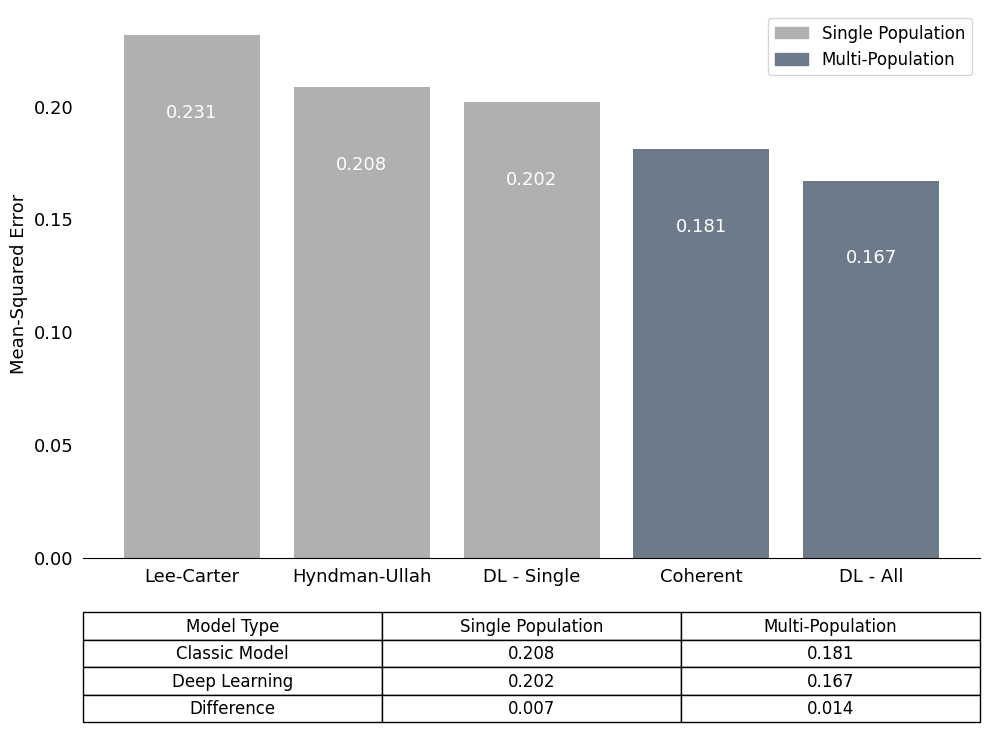

In [18]:
# data
from matplotlib import patches


overalls = np.array([lc_overall_ave, hu_overall_ave, single_overall_ave, coh_overall_ave, dl_overall_ave])
labels = ['Lee-Carter', 'Hyndman-Ullah', 'DL - Single', 'Coherent', 'DL - All']

# Define bar colors: light gray for single-country, darker gray-blue for multi-country
bar_colors = ['#B0B0B0', '#B0B0B0', '#B0B0B0', '#6C7A89', '#6C7A89']  # Soft neutral tones

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))
#fig.patch.set_facecolor('white')

bars = ax.bar(labels, overalls, color=bar_colors)

# Clean axes
#ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelsize=13)

# Bar labels
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval - 0.03,
        f'{yval:.3f}',
        ha='center',
        va='top',
        fontsize=13,
        color='white' if yval > 0.15 else 'black'
    )

# Legend with neutral tones
legend_handles = [
    patches.Patch(color='#B0B0B0', label='Single Population'),
    patches.Patch(color='#6C7A89', label='Multi-Population')
]
ax.legend(handles=legend_handles, fontsize=12, loc='upper right')

# Final labels
ax.set_ylabel('Mean-Squared Error', fontsize=13)
ax.set_xlabel('')

# add differences
diffs1 = hu_overall_ave - single_overall_ave 
diffs2 = coh_overall_ave - dl_overall_ave

# Add table
table_data = [
    ['Classic Model', f'{hu_overall_ave:.3f}', f'{coh_overall_ave:.3f}'],
    ['Deep Learning', f'{single_overall_ave:.3f}', f'{dl_overall_ave:.3f}'],
    ['Difference', f'{diffs1:.3f}', f'{diffs2:.3f}']
]
column_labels = ['Model Type', 'Single Population', 'Multi-Population']

table = plt.table(
    cellText=table_data,
    colLabels=column_labels,
    cellLoc='center',
    loc='bottom',
    bbox=[0.0, -0.3, 1, 0.2]
)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.subplots_adjust(left=0.1, bottom=0.3)
plt.tight_layout()
plt.savefig("../results/overall_barplot_with_table_aug.pdf", format="pdf", bbox_inches='tight', transparent=True)
plt.show()

### Results by country (Table 1)

In [19]:
overalls = np.array([lc_overall_ave, hu_overall_ave, single_overall_ave, coh_overall_ave, dl_overall_ave])
labels = ['Lee-Carter', 'Hyndman-Ullah', 'Single Population DL', 'Coherent', 'All Country DL']

In [20]:
mse_results_by_country = np.column_stack((lc_ave_by_country, hu_ave_by_country, single_ave_by_country, coh_ave_by_country, dl_ave_by_country))

In [22]:
new_mses = np.vstack([mse_results_by_country, overalls])

In [23]:
# add a row to geos_key for overall mses
geos_key
new = np.array([["Overall", 90]])
geos_key_with_overall = np.vstack([geos_key, new])

In [24]:
# change geo abbreviations to full name for table
full_names_mapping = {
    # US states
    'AK': 'Alaska', 'AL': 'Alabama', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky',
    'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
    'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',

    # Countries
    'AUS': 'Australia', 'AUT': 'Austria', 'BEL': 'Belgium', 'BGR': 'Bulgaria', 'BLR': 'Belarus',
    'CAN': 'Canada', 'CHE': 'Switzerland', 'CZE': 'Czech Republic', 'DNK': 'Denmark', 'DEUTE': 'East Germany',
    'DEUTW': 'West Germany',
    'ESP': 'Spain', 'EST': 'Estonia', 'FIN': 'Finland', 'FRATNP': 'France',
    'GBRTENW': 'England and Wales', 'GBR_NIR': 'Northern Ireland',
    'GBR_SCO': 'Scotland', 'GRC': 'Greece', 'HUN': 'Hungary', 'IRL': 'Ireland',
    'ISL': 'Iceland', 'ISR': 'Israel', 'ITA': 'Italy', 'JPN': 'Japan', 'LTU': 'Lithuania',
    'LUX': 'Luxembourg', 'LVA': 'Latvia', 'NLD': 'Netherlands', 'NOR': 'Norway',
    'NZL_NP': 'New Zealand', 'POL': 'Poland', 'PRT': 'Portugal', 'RUS': 'Russia',
    'SVK': 'Slovakia', 'SVN': 'Slovenia', 'SWE': 'Sweden', 'TWN': 'Taiwan',
    'UKR': 'Ukraine', 'USA': 'United States', 'NZL_NM': 'New Zealand',
    'Overall': 'Overall'
}

# Convert existing array
geos_key_full_names = np.array([
    [full_names_mapping.get(code, code), idx] for code, idx in geos_key_with_overall
])

In [25]:
percent_improvement_all_countries = []
for i in range(0,len(np.unique(country_training[:,0]))+1):
    val = (1 - new_mses[i][4] / new_mses[i][3]) * 100
    percent_improvement_all_countries.append(val)


In [26]:
mses_with_percent_imp = np.column_stack((new_mses, percent_improvement_all_countries))

In [27]:
# create a DataFrame
df_mse = pd.DataFrame(
    mses_with_percent_imp,
    columns=['LC', 'HU', 'DL Single', 'Coherent', 'DL All', "\% Impr. DL vs Coherent"],
    index=[geos_key_full_names[i+50, 0] for i in range(len(new_mses))]
)
# round
df_mse = df_mse.round(3)


# sort by the last column in descending order
df_data = df_mse.iloc[:-1]
df_overall = df_mse.iloc[-1:]
df_data_sorted = df_data.sort_values(by="\% Impr. DL vs Coherent", ascending=False)

# concatenate the sorted data with the overall row at the end
df_final = pd.concat([df_data_sorted, df_overall])

# convert the DataFrame to a LaTeX formatted table
latex_table = df_final.to_latex(index=True, float_format="%.3f")

# display the LaTeX code
print(latex_table)


\begin{tabular}{lrrrrrr}
\toprule
 & LC & HU & DL Single & Coherent & DL All & \% Impr. DL vs Coherent \\
\midrule
Ukraine & 0.083 & 0.086 & 0.058 & 0.050 & 0.025 & 48.623 \\
Spain & 0.091 & 0.073 & 0.049 & 0.065 & 0.044 & 32.847 \\
Hungary & 0.202 & 0.114 & 0.068 & 0.080 & 0.057 & 28.666 \\
Belarus & 0.142 & 0.142 & 0.113 & 0.069 & 0.053 & 23.327 \\
Switzerland & 0.137 & 0.123 & 0.100 & 0.121 & 0.097 & 19.961 \\
Russia & 0.120 & 0.102 & 0.102 & 0.040 & 0.032 & 19.415 \\
Finland & 0.151 & 0.140 & 0.139 & 0.135 & 0.110 & 18.663 \\
Slovenia & 0.699 & 0.616 & 0.662 & 0.538 & 0.457 & 15.048 \\
Belgium & 0.063 & 0.062 & 0.057 & 0.054 & 0.046 & 13.796 \\
Ireland & 0.140 & 0.138 & 0.122 & 0.122 & 0.106 & 13.336 \\
Lithuania & 0.196 & 0.198 & 0.174 & 0.169 & 0.148 & 12.361 \\
Australia & 0.040 & 0.036 & 0.027 & 0.030 & 0.026 & 11.662 \\
France & 0.030 & 0.017 & 0.019 & 0.018 & 0.016 & 10.577 \\
Bulgaria & 0.084 & 0.085 & 0.057 & 0.047 & 0.043 & 10.213 \\
Austria & 0.074 & 0.068 & 0.067 & 0.070

<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
/var/folders/9w/c0r00l9s0hschsd5nsg179tm0000gn/T/ipykernel_1175/589289335.py:4: SyntaxWarning: invalid escape sequence '\%'
  columns=['LC', 'HU', 'DL Single', 'Coherent', 'DL All', "\% Impr. DL vs Coherent"],
/var/folders/9w/c0r00l9s0hschsd5nsg179tm0000gn/T/ipykernel_1175/589289335.py:14: SyntaxWarning: invalid escape sequence '\%'
  df_data_sorted = df_data.sort_values(by="\% Impr. DL vs Coherent", ascending=False)


### Top performers (Figure 3)

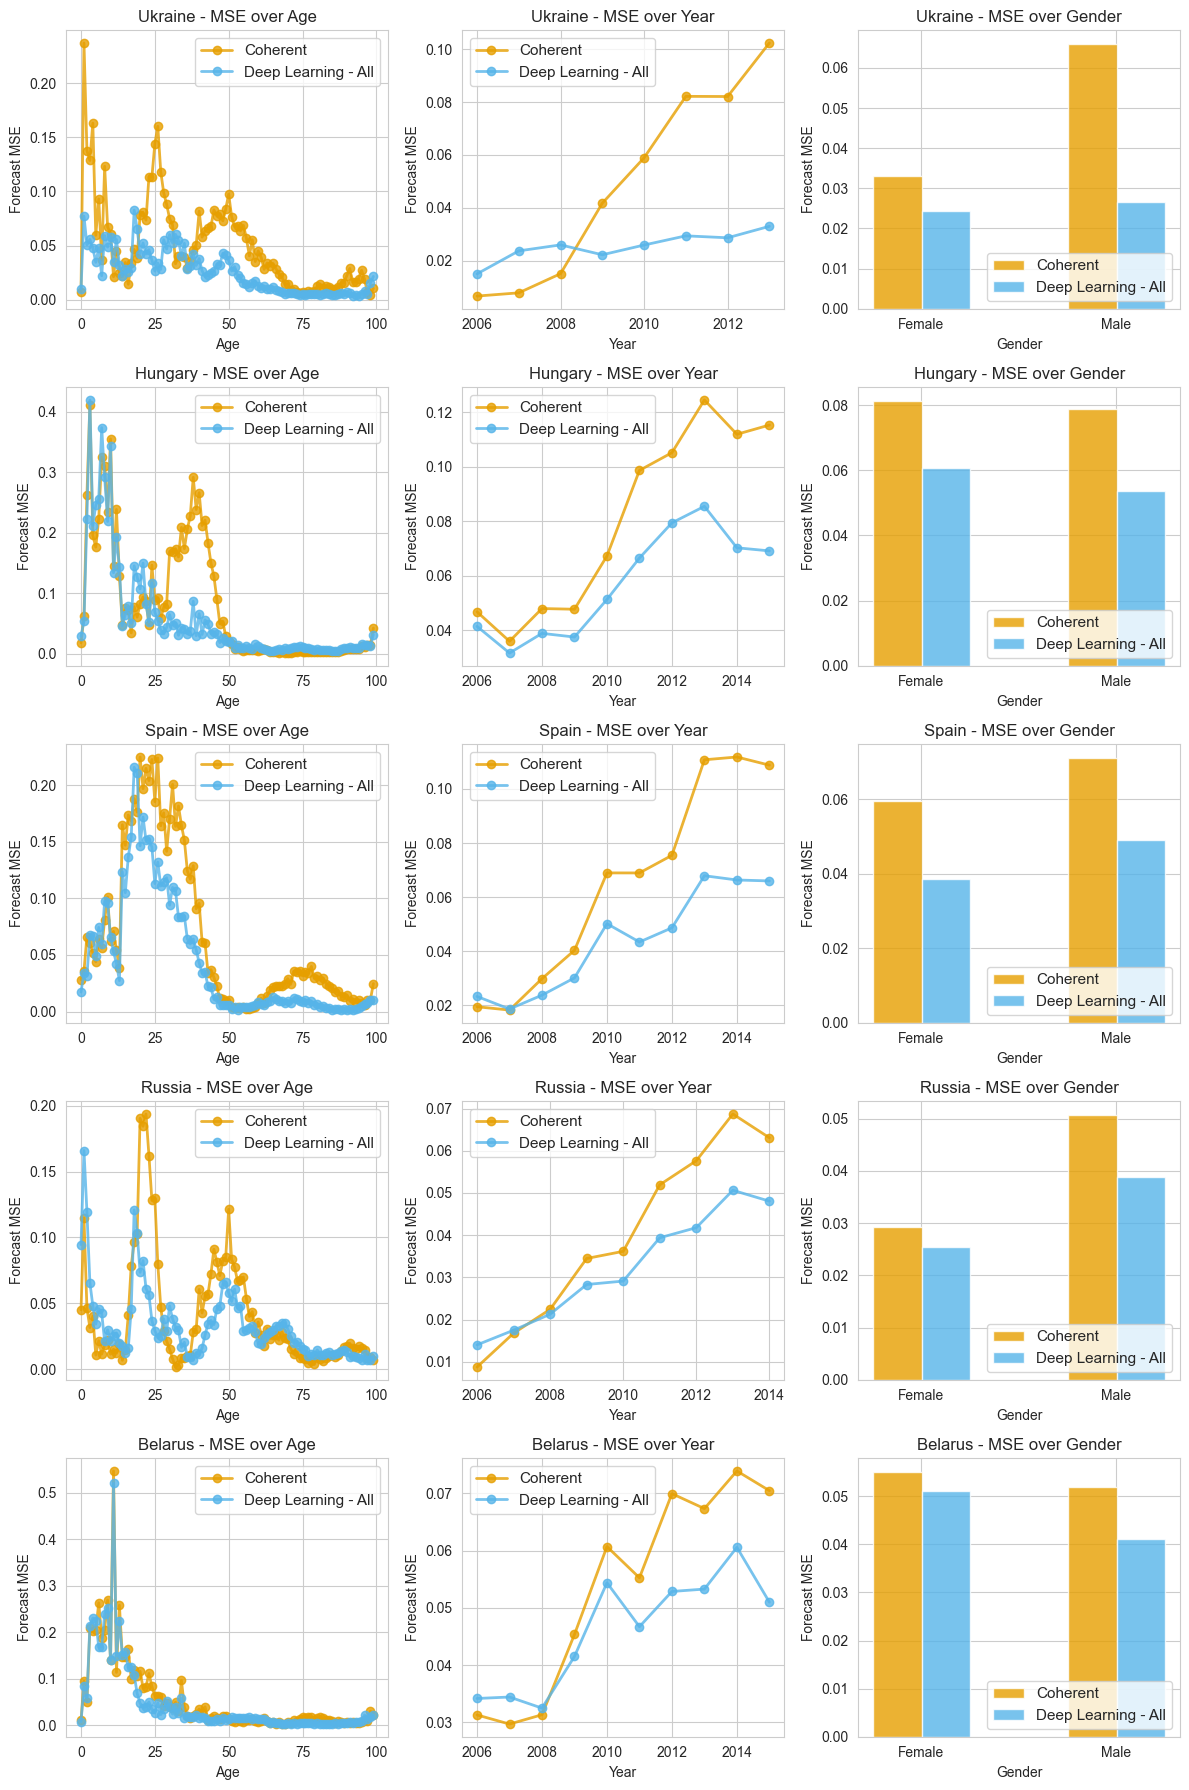

In [28]:
# Simple top performer / US figures 
sns.set_style("whitegrid")
palette = ["#E69F00", "#56B4E9", "#009E73"]  # orange, sky blue, green

def compute_avg_mses(country_index, feature_index):
    model_data = {
        "Coherent": c_test_divided,
        "Deep Learning - All": dl_test_divided
    }
    avg_mses = {}

    for label, test_data in model_data.items():
        mse_list = []
        for i in range(5):
            mse, _, _ = evaluation_functions.calculate_error_by_category(
                test_data[i][country_index],
                actual_data_divided[country_index],
                feature_index=feature_index
            )
            mse_list.append(mse)

        combined = {}
        for d in mse_list:
            for k, v in d.items():
                if k not in combined:
                    combined[k] = [v, 1]
                else:
                    combined[k][0] += v
                    combined[k][1] += 1
        avg_mses[label] = {k: total / count for k, (total, count) in combined.items()}

    return avg_mses

countries = {"Ukraine": 38, "Hungary": 19, "Spain": 11, "Russia": 33, "Belarus": 2}
features = {"Age": 3, "Year": 2, "Gender": 1}  # Note: "Gender" has feature_index = 1

fig, axes = plt.subplots(5, 3, figsize=(12, 18), sharey=False)
axes = axes.flatten()

for idx, (country_name, country_index) in enumerate(countries.items()):
    for jdx, (feature_name, feature_index) in enumerate(features.items()):
        avg_mses = compute_avg_mses(country_index, feature_index)
        ax = axes[idx * len(features) + jdx]  # Corrected indexing

        for i, (label, data) in enumerate(avg_mses.items()):
            keys, values = zip(*sorted(data.items()))

            if feature_index == 1:  # Gender (categorical)
                x = np.arange(len(keys)) + i * 0.25  # offset bars
                ax.bar(x, values, width=0.25, label=label, alpha=0.8, color=palette[i])
                gender_labels = ['Female' if k == 0 else 'Male' for k in keys]
                ax.set_xticks(np.arange(len(keys)) + 0.12)
                ax.set_xticklabels(gender_labels)
                ax.legend(fontsize=11, loc='lower right', frameon=True)
            else:
                ax.plot(keys, values, label=label, linestyle='-', marker='o',
                        linewidth=2, alpha=0.8, color=palette[i])
                ax.legend(fontsize=11, loc='best', frameon=True)

        ax.set_title(f"{country_name} - MSE over {feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Forecast MSE")
        

plt.tight_layout()
plt.savefig("../results/top_5x3_july.pdf", format="pdf", bbox_inches="tight")
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})
plt.show()


# US (Figure 4)

In [29]:
# Set country index to 50 - geos_key
country_index = 39

In [30]:
# coherent average mses
c_mse_list = []
c_rmse_list = []
c_rrmse_list = []

for i in range(5):
    c_mse, c_rmse, c_rrmse = evaluation_functions.calculate_error_by_category(c_test_divided[i][country_index], actual_data_divided[country_index], feature_index=3) # 3 is age 
    c_mse_list.append(c_mse)
    c_rmse_list.append(c_rmse)
    c_rrmse_list.append(c_rrmse)

combined = {}

for d in c_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

c_ave_mses_age = {k: total / count for k, (total, count) in combined.items()}

In [31]:
dl_mse_list = []
dl_rmse_list = []
dl_rrmse_list = []

for i in range(5):
    dl_mse, dl_rmse, dl_rrmse = evaluation_functions.calculate_error_by_category(dl_test_divided[i][country_index], actual_data_divided[country_index], feature_index=3) 
    dl_mse_list.append(dl_mse)
    dl_rmse_list.append(dl_rmse)
    dl_rrmse_list.append(dl_rrmse)

combined = {}

for d in dl_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

dl_ave_mses_age = {k: total / count for k, (total, count) in combined.items()}

In [32]:
combined_index = 89
combined_mse_list = []
combined_rmse_list = []
combined_rrmse_list = []

for i in range(5):
    combined_mse, combined_rmse, combined_rrmse = evaluation_functions.calculate_error_by_category(combined_test_divided[i][combined_index], actual_combined_divided[combined_index], feature_index=3) 
    combined_mse_list.append(combined_mse)
    combined_rmse_list.append(combined_rmse)
    combined_rrmse_list.append(combined_rrmse)

combined = {}

for d in combined_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

combined_ave_mses_age = {k: total / count for k, (total, count) in combined.items()}

Getting results by year 

In [33]:
# coherent average mses
c_mse_list = []
c_rmse_list = []
c_rrmse_list = []

for i in range(5):
    c_mse, c_rmse, c_rrmse = evaluation_functions.calculate_error_by_category(c_test_divided[i][country_index], actual_data_divided[country_index], feature_index=2) 
    c_mse_list.append(c_mse)
    c_rmse_list.append(c_rmse)
    c_rrmse_list.append(c_rrmse)

combined = {}

for d in c_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

c_ave_mses_year = {k: total / count for k, (total, count) in combined.items()}

In [34]:
dl_mse_list = []
dl_rmse_list = []
dl_rrmse_list = []

for i in range(5):
    dl_mse, dl_rmse, dl_rrmse = evaluation_functions.calculate_error_by_category(dl_test_divided[i][country_index], actual_data_divided[country_index], feature_index=2) 
    dl_mse_list.append(dl_mse)
    dl_rmse_list.append(dl_rmse)
    dl_rrmse_list.append(dl_rrmse)

combined = {}

for d in dl_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

dl_ave_mses_year = {k: total / count for k, (total, count) in combined.items()}

In [35]:
combined_index = 89
combined_mse_list = []
combined_rmse_list = []
combined_rrmse_list = []

for i in range(5):
    combined_mse, combined_rmse, combined_rrmse = evaluation_functions.calculate_error_by_category(combined_test_divided[i][combined_index], actual_combined_divided[combined_index], feature_index=2) 
    combined_mse_list.append(combined_mse)
    combined_rmse_list.append(combined_rmse)
    combined_rrmse_list.append(combined_rrmse)

combined = {}

for d in combined_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

combined_ave_mses_year = {k: total / count for k, (total, count) in combined.items()}

Getting results by gender

In [36]:
# coherent average mses
c_mse_list = []
c_rmse_list = []
c_rrmse_list = []

for i in range(5):
    c_mse, c_rmse, c_rrmse = evaluation_functions.calculate_error_by_category(c_test_divided[i][country_index], actual_data_divided[country_index], feature_index=1) 
    c_mse_list.append(c_mse)
    c_rmse_list.append(c_rmse)
    c_rrmse_list.append(c_rrmse)

combined = {}

for d in c_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

c_ave_mses_gender = {k: total / count for k, (total, count) in combined.items()}

In [37]:
dl_mse_list = []
dl_rmse_list = []
dl_rrmse_list = []

for i in range(5):
    dl_mse, dl_rmse, dl_rrmse = evaluation_functions.calculate_error_by_category(dl_test_divided[i][country_index], actual_data_divided[country_index], feature_index=1) 
    dl_mse_list.append(dl_mse)
    dl_rmse_list.append(dl_rmse)
    dl_rrmse_list.append(dl_rrmse)

combined = {}

for d in dl_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

dl_ave_mses_gender = {k: total / count for k, (total, count) in combined.items()}

In [38]:
combined_index = 89
combined_mse_list = []
combined_rmse_list = []
combined_rrmse_list = []

for i in range(5):
    combined_mse, combined_rmse, combined_rrmse = evaluation_functions.calculate_error_by_category(combined_test_divided[i][combined_index], actual_combined_divided[combined_index], feature_index=1) 
    combined_mse_list.append(combined_mse)
    combined_rmse_list.append(combined_rmse)
    combined_rrmse_list.append(combined_rrmse)

combined = {}

for d in combined_mse_list:
    for k, v in d.items():
        if k not in combined:
            combined[k] = [v, 1]  # [sum, count]
        else:
            combined[k][0] += v
            combined[k][1] += 1

combined_ave_mses_gender = {k: total / count for k, (total, count) in combined.items()}

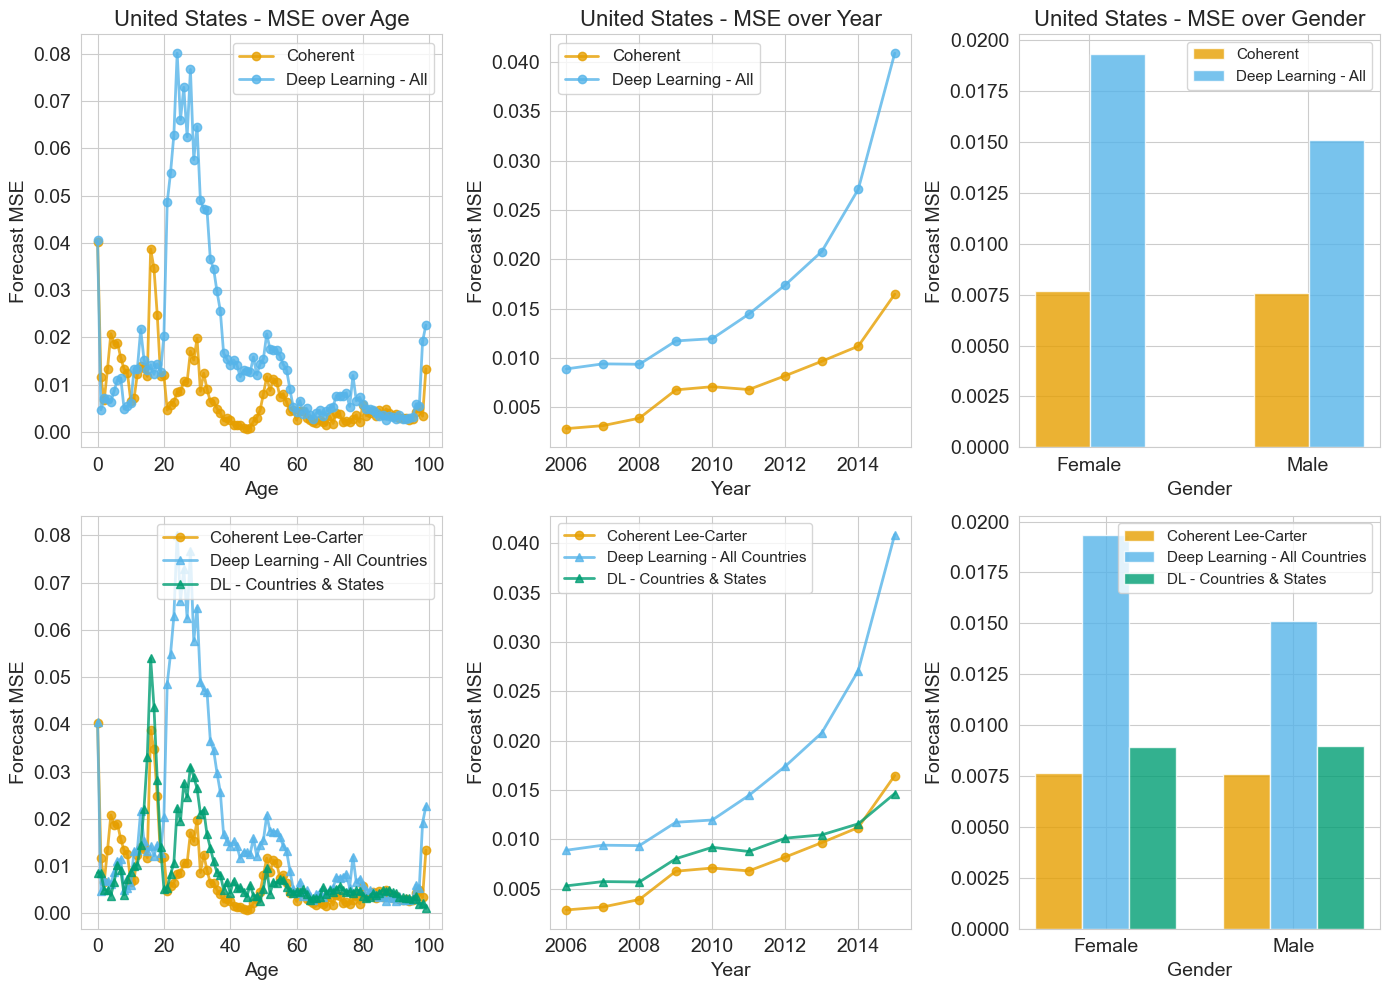

In [39]:
#sns.set_style("whitegrid")
palette = ["#E69F00", "#56B4E9", "#009E73"]

# Prepare the sorted data
# For Age
keys1_age, values1_age = zip(*sorted(c_ave_mses_age.items()))
keys2_age, values2_age = zip(*sorted(dl_ave_mses_age.items()))
keys3_age, values3_age = zip(*sorted(combined_ave_mses_age.items()))

# For Year
keys1_year, values1_year = zip(*sorted((int(k), v) for k, v in c_ave_mses_year.items()))
keys2_year, values2_year = zip(*sorted((int(k), v) for k, v in dl_ave_mses_year.items()))
keys3_year, values3_year = zip(*sorted((int(k), v) for k, v in combined_ave_mses_year.items()))

# For Year
keys1_gender, values1_gender = zip(*sorted(c_ave_mses_gender.items()))
keys2_gender, values2_gender = zip(*sorted(dl_ave_mses_gender.items()))
keys3_gender, values3_gender = zip(*sorted(combined_ave_mses_gender.items()))

fig, axes = plt.subplots(2, 3, figsize=(14, 10))  # 2 rows, 3 columns
axes = axes.flatten()

# --- Top row: Individual country results (e.g., United States) ---
countries = {"United States": 39}
features = {"Age": 3, "Year": 2, "Gender": 1}

for idx, (country_name, country_index) in enumerate(countries.items()):
    for jdx, (feature_name, feature_index) in enumerate(features.items()):
        avg_mses = compute_avg_mses(country_index, feature_index)
        ax = axes[idx * len(features) + jdx]  # Corrected indexing

        for i, (label, data) in enumerate(avg_mses.items()):
            keys, values = zip(*sorted(data.items()))

            if feature_index == 1:  # Gender (categorical)
                x = np.arange(len(keys)) + i * 0.25  # offset bars
                ax.bar(x, values, width=0.25, label=label, alpha=0.8, color=palette[i])
                gender_labels = ['Female' if k == 0 else 'Male' for k in keys]
                ax.set_xticks(np.arange(len(keys)) + 0.12)
                ax.set_xticklabels(gender_labels)
                ax.legend(fontsize=11, loc='upper right')
            else:
                ax.plot(keys, values, label=label, linestyle='-', marker='o',
                        linewidth=2, alpha=0.8, color=palette[i])
                ax.legend(fontsize=12, loc='best')

        ax.set_title(f"{country_name} - MSE over {feature_name}")
        ax.set_xlabel(feature_name, fontsize=14)
        ax.set_ylabel("Forecast MSE", fontsize=14)

# --- Bottom row: Combined model comparisons ---
# Age
axes[3].plot(keys1_age, values1_age, label="Coherent Lee-Carter", color=palette[0], linestyle='-', marker='o', linewidth=2, alpha=0.8)
axes[3].plot(keys2_age, values2_age, label="Deep Learning - All Countries", color=palette[1], linestyle='-', marker='^', linewidth=2, alpha=0.8)
axes[3].plot(keys3_age, values3_age, label="DL - Countries & States", color=palette[2], linestyle='-', marker='^', linewidth=2, alpha=0.8)
axes[3].set_xlabel("Age", fontsize=14)
axes[3].set_ylabel("Forecast MSE", fontsize=14)
axes[3].legend(fontsize=12)

# Year
axes[4].plot(keys1_year, values1_year, label="Coherent Lee-Carter", color=palette[0], linestyle='-', marker='o', linewidth=2, alpha=0.8)
axes[4].plot(keys2_year, values2_year, label="Deep Learning - All Countries", color=palette[1], linestyle='-', marker='^', linewidth=2, alpha=0.8)
axes[4].plot(keys3_year, values3_year, label="DL - Countries & States", color=palette[2], linestyle='-', marker='^', linewidth=2, alpha=0.8)
axes[4].set_xlabel("Year", fontsize=14)
axes[4].set_ylabel("Forecast MSE", fontsize=14)
axes[4].legend(fontsize=11)

# Gender
ax = axes[5]
keys = list(keys1_gender)  # should be [0, 1]
x = np.arange(len(keys))

bar_width = 0.25

# Offset each set of bars
ax.bar(x - bar_width, values1_gender, width=bar_width, label="Coherent Lee-Carter", color=palette[0], alpha=0.8)
ax.bar(x, values2_gender, width=bar_width, label="Deep Learning - All Countries", color=palette[1], alpha=0.8)
ax.bar(x + bar_width, values3_gender, width=bar_width, label="DL - Countries & States", color=palette[2], alpha=0.8)

# Labeling
gender_labels = ['Female' if k == 0 else 'Male' for k in keys]
ax.set_xticks(x)
ax.set_xticklabels(gender_labels)

ax.set_xlabel("Gender", fontsize=14)
ax.set_ylabel("Forecast MSE", fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig("../results/combined_us_july.pdf", format="pdf", bbox_inches="tight")
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})
plt.show()
